In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/ActiveLearningML/

/content/gdrive/MyDrive/ActiveLearningML


In [ ]:
!ls

winequality-red.csv


In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
os.chdir('/content/gdrive/My Drive/ActiveLearningML/')

In [ ]:
wine_df = pd.read_csv('winequality-red.csv')
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
!pip install modAL

In [ ]:
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [ ]:
wine_train, wine_pool = train_test_split(wine_df, test_size = 0.9, random_state=21)

In [ ]:
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
630,8.7,0.540,0.26,2.5,0.097,7.0,31.0,0.99760,3.27,0.60,9.3,6
1060,11.6,0.230,0.57,1.8,0.074,3.0,8.0,0.99810,3.14,0.70,9.9,6
1463,6.9,0.630,0.01,2.4,0.076,14.0,39.0,0.99522,3.34,0.53,10.8,6
334,7.9,0.650,0.01,2.5,0.078,17.0,38.0,0.99630,3.34,0.74,11.7,7
1025,8.6,0.830,0.00,2.8,0.095,17.0,43.0,0.99822,3.33,0.60,10.4,6
...,...,...,...,...,...,...,...,...,...,...,...,...
368,10.3,0.340,0.52,2.8,0.159,15.0,75.0,0.99980,3.18,0.64,9.4,5
48,6.4,0.400,0.23,1.6,0.066,5.0,12.0,0.99580,3.34,0.56,9.2,5
772,9.5,0.570,0.27,2.3,0.082,23.0,144.0,0.99782,3.27,0.55,9.4,5
1231,7.8,0.815,0.01,2.6,0.074,48.0,90.0,0.99621,3.38,0.62,10.8,5


In [ ]:
y_train = wine_train['quality']
y_train

630     6
1060    6
1463    6
334     7
1025    6
       ..
368     5
48      5
772     5
1231    5
969     5
Name: quality, Length: 159, dtype: int64

In [ ]:
y_train.unique()

array([6, 7, 5, 4, 8, 3])

In [ ]:
x_train = wine_train.drop('quality', axis =1)
x_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
630,8.7,0.540,0.26,2.5,0.097,7.0,31.0,0.99760,3.27,0.60,9.3
1060,11.6,0.230,0.57,1.8,0.074,3.0,8.0,0.99810,3.14,0.70,9.9
1463,6.9,0.630,0.01,2.4,0.076,14.0,39.0,0.99522,3.34,0.53,10.8
334,7.9,0.650,0.01,2.5,0.078,17.0,38.0,0.99630,3.34,0.74,11.7
1025,8.6,0.830,0.00,2.8,0.095,17.0,43.0,0.99822,3.33,0.60,10.4
...,...,...,...,...,...,...,...,...,...,...,...
368,10.3,0.340,0.52,2.8,0.159,15.0,75.0,0.99980,3.18,0.64,9.4
48,6.4,0.400,0.23,1.6,0.066,5.0,12.0,0.99580,3.34,0.56,9.2
772,9.5,0.570,0.27,2.3,0.082,23.0,144.0,0.99782,3.27,0.55,9.4
1231,7.8,0.815,0.01,2.6,0.074,48.0,90.0,0.99621,3.38,0.62,10.8


In [ ]:
x_train = x_train.to_numpy()

In [ ]:
y_train = y_train.to_numpy()

In [ ]:
y_pool = wine_pool['quality']
x_pool= wine_pool.drop('quality', axis = 1)

In [ ]:
x_pool = x_pool.to_numpy()
y_pool = y_pool.to_numpy()

In [ ]:
y = wine_df['quality']
x = wine_df.drop('quality', axis = 1)

In [ ]:
y = y.to_numpy()
x = x.to_numpy()

In [ ]:
# Initializing a learner with RandomForestClassifier as base model and uncertainty sampling.
learner = ActiveLearner(
    estimator = RandomForestClassifier(),
    X_training = x_train, y_training = y_train
)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
# Predictions made by base active learning model on the original dataset.
predictions = learner.predict(x)
is_correct = (predictions == y)
predictions

array([5, 5, 5, ..., 6, 5, 6])

In [ ]:
unqueried_score = learner.score(x, y)
unqueried_score

0.6122576610381488

In [ ]:
# We apply PCA for visualization purposes.
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 20)
transformed_wine = pca.fit_transform(X = x)

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
x_component, y_component = transformed_wine[:, 0], transformed_wine[:, 1]

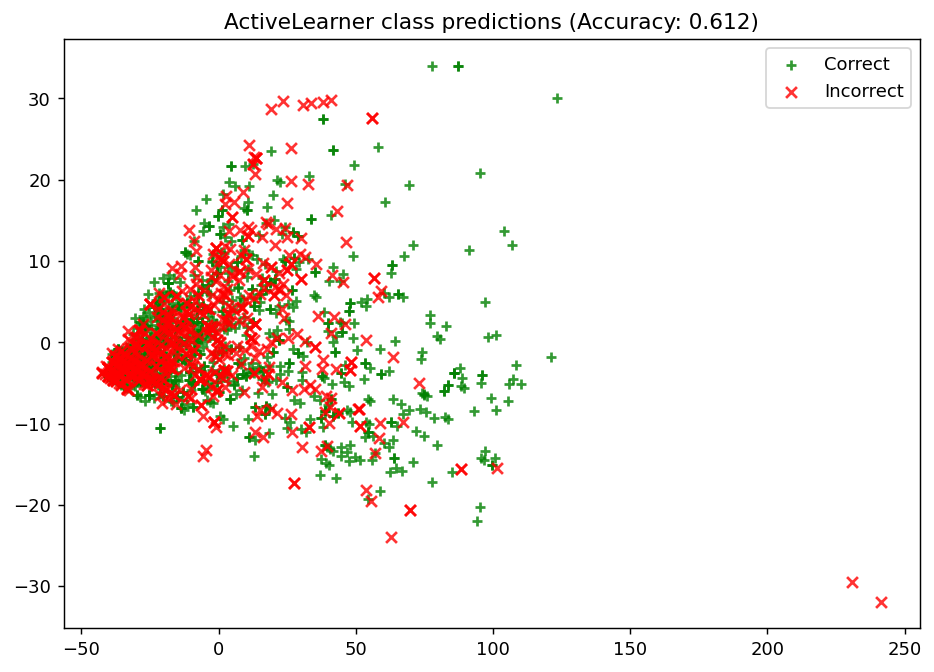

In [ ]:
# Plotting to show how many points have been correctly classified and incorrectly classified.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 640
performance_history = [unqueried_score]
checkpoints= []

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(x_pool)

  # Teach our ActiveLearner model the record it has requested.
  learner.teach(X=x_pool[query_index], y=y_pool[query_index])

  # Remove the queried instance from the unlabeled pool.
  x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(x, y)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

  if (index+1)%160 == 0:
    checkpoints.append(model_accuracy)
    print('Checkpoint Accuracy: {acc: 0.4f}'.format(acc = model_accuracy))

Accuracy after query 1: 0.6141
Accuracy after query 2: 0.6335
Accuracy after query 3: 0.6229
Accuracy after query 4: 0.6223
Accuracy after query 5: 0.6160
Accuracy after query 6: 0.6285
Accuracy after query 7: 0.6310
Accuracy after query 8: 0.6148
Accuracy after query 9: 0.6248
Accuracy after query 10: 0.6179
Accuracy after query 11: 0.6160
Accuracy after query 12: 0.6273
Accuracy after query 13: 0.6223
Accuracy after query 14: 0.6223
Accuracy after query 15: 0.6298
Accuracy after query 16: 0.6223
Accuracy after query 17: 0.6298
Accuracy after query 18: 0.6304
Accuracy after query 19: 0.6304
Accuracy after query 20: 0.6216
Accuracy after query 21: 0.6366
Accuracy after query 22: 0.6298
Accuracy after query 23: 0.6398
Accuracy after query 24: 0.6366
Accuracy after query 25: 0.6335
Accuracy after query 26: 0.6423
Accuracy after query 27: 0.6373
Accuracy after query 28: 0.6423
Accuracy after query 29: 0.6341
Accuracy after query 30: 0.6379
Accuracy after query 31: 0.6485
Accuracy after qu

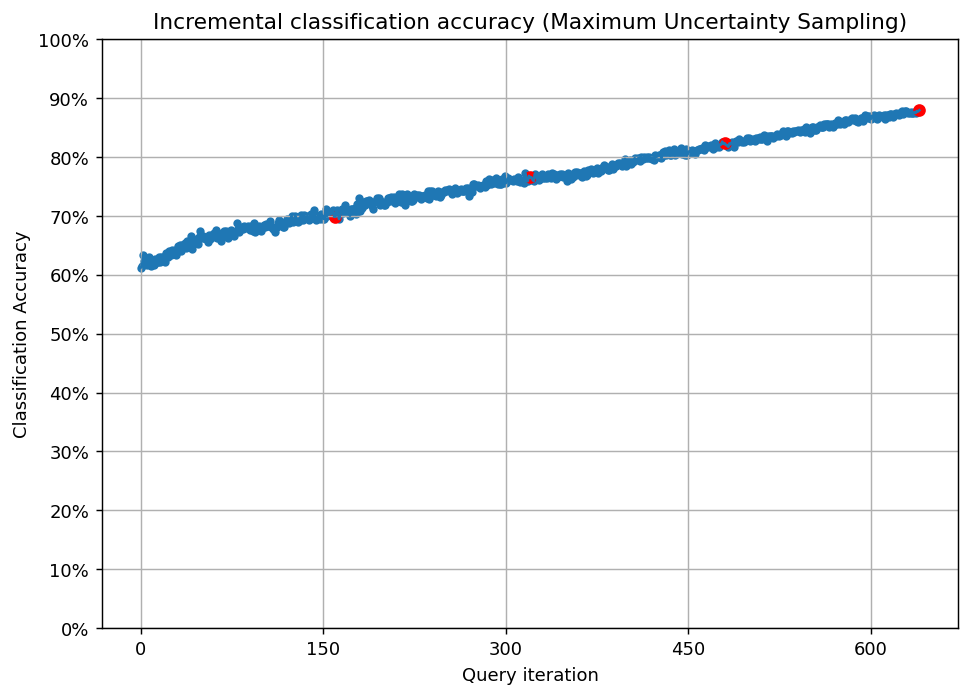

In [ ]:
# Plot our performance over time.
x_list = []
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

for i in range(len(checkpoints)):
  x_c = (i + 1)*160
  x_list.append(x_c)

ax.scatter(x_list, checkpoints, color ='red')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy (Maximum Uncertainty Sampling)')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
predictions = learner.predict(x)
is_correct = (predictions == y)

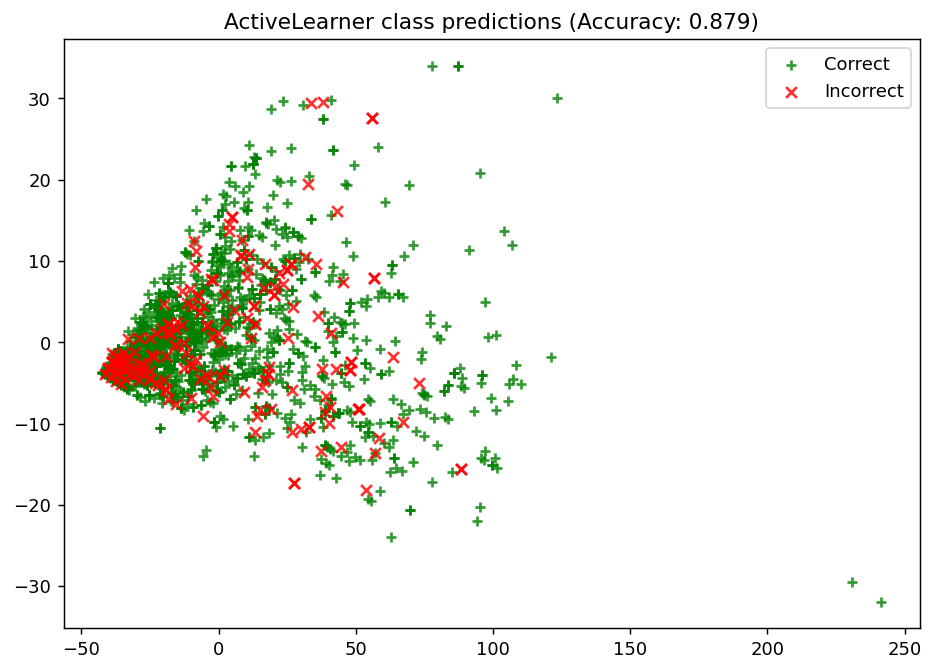

In [ ]:
# Plotting to show how many points have been correctly classified and incorrectly classified.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=performance_history[-1]))
plt.show()

In [ ]:
from modAL.uncertainty import entropy_sampling

learner_entropy = ActiveLearner(
    estimator = RandomForestClassifier(),
    X_training = x_train, y_training = y_train,
    query_strategy = entropy_sampling
)

In [ ]:
y_pool = wine_pool['quality']
x_pool= wine_pool.drop('quality', axis = 1)
x_pool = x_pool.to_numpy()
y_pool = y_pool.to_numpy()

In [ ]:
predictions = learner_entropy.predict(x)
is_correct = (predictions == y)
predictions

array([5, 5, 5, ..., 6, 5, 6])

In [ ]:
unqueried_score = learner_entropy.score(x, y)

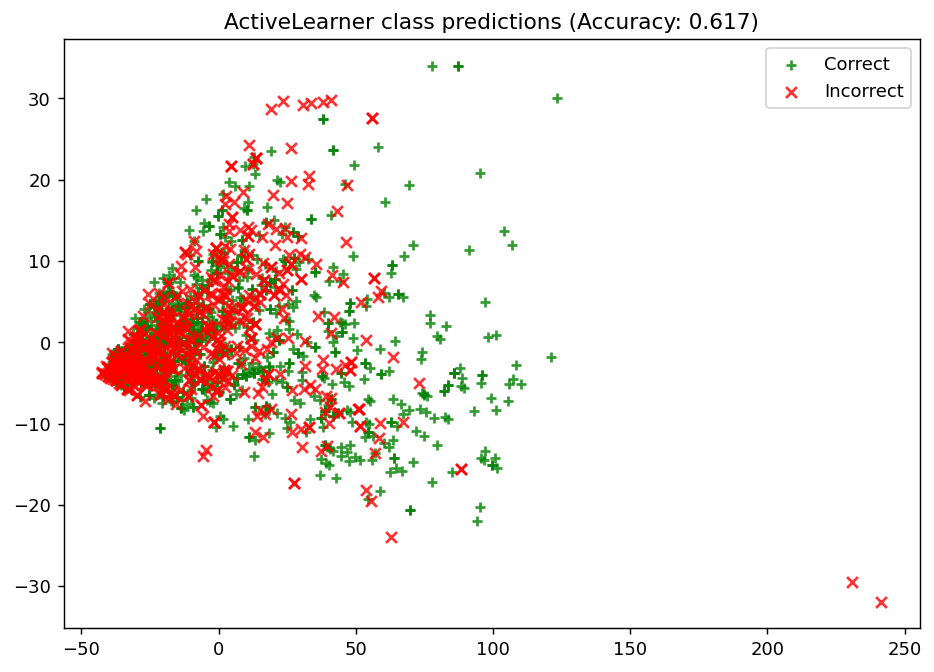

In [ ]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 640
performance_history = [unqueried_score]
checkpoints = []

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (entropy sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner_entropy.query(x_pool)

  # Teach our ActiveLearner model the record it has requested.
  learner_entropy.teach(X=x_pool[query_index], y=y_pool[query_index])

  # Remove the queried instance from the unlabeled pool.
  x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner_entropy.score(x, y)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

  if (index+1)%160 == 0:
    checkpoints.append(model_accuracy)
    print('Checkpoint Accuracy: {acc: 0.4f}'.format(acc = model_accuracy))

Accuracy after query 1: 0.6185
Accuracy after query 2: 0.6104
Accuracy after query 3: 0.6185
Accuracy after query 4: 0.6191
Accuracy after query 5: 0.6091
Accuracy after query 6: 0.6210
Accuracy after query 7: 0.6185
Accuracy after query 8: 0.6173
Accuracy after query 9: 0.6223
Accuracy after query 10: 0.6216
Accuracy after query 11: 0.6191
Accuracy after query 12: 0.6041
Accuracy after query 13: 0.6135
Accuracy after query 14: 0.6329
Accuracy after query 15: 0.6260
Accuracy after query 16: 0.6248
Accuracy after query 17: 0.6254
Accuracy after query 18: 0.6141
Accuracy after query 19: 0.6323
Accuracy after query 20: 0.6279
Accuracy after query 21: 0.6204
Accuracy after query 22: 0.6210
Accuracy after query 23: 0.6223
Accuracy after query 24: 0.6241
Accuracy after query 25: 0.6316
Accuracy after query 26: 0.6329
Accuracy after query 27: 0.6429
Accuracy after query 28: 0.6460
Accuracy after query 29: 0.6341
Accuracy after query 30: 0.6316
Accuracy after query 31: 0.6260
Accuracy after qu

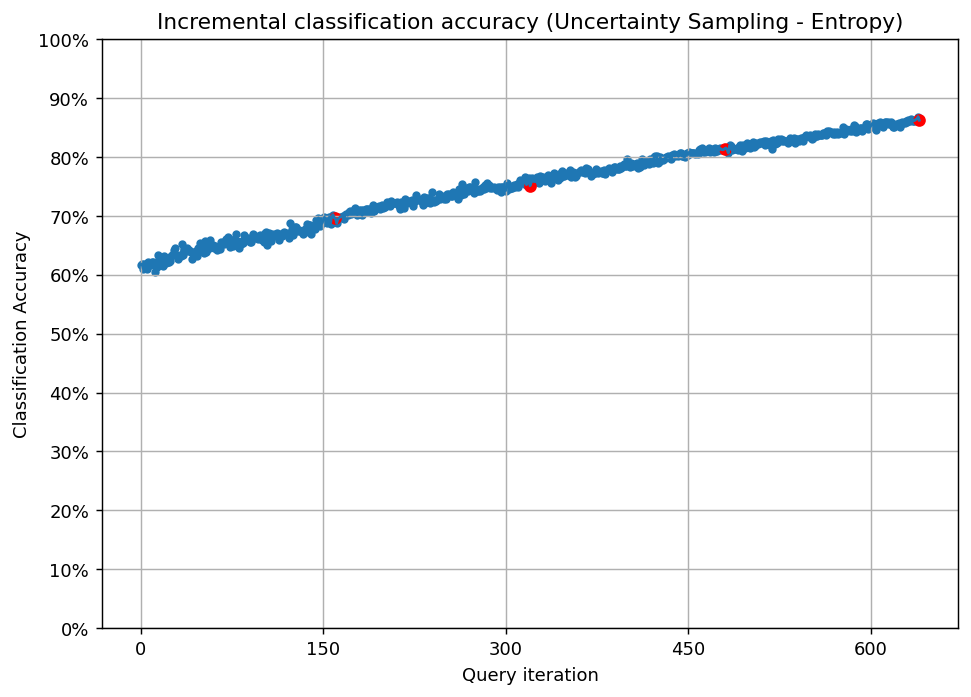

In [ ]:
# Plot our performance over time.
x_list = []
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

for i in range(len(checkpoints)):
  x_c = (i + 1)*160
  x_list.append(x_c)

ax.scatter(x_list, checkpoints, color ='red')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy (Uncertainty Sampling - Entropy)')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
predictions = learner_entropy.predict(x)
is_correct = (predictions == y)

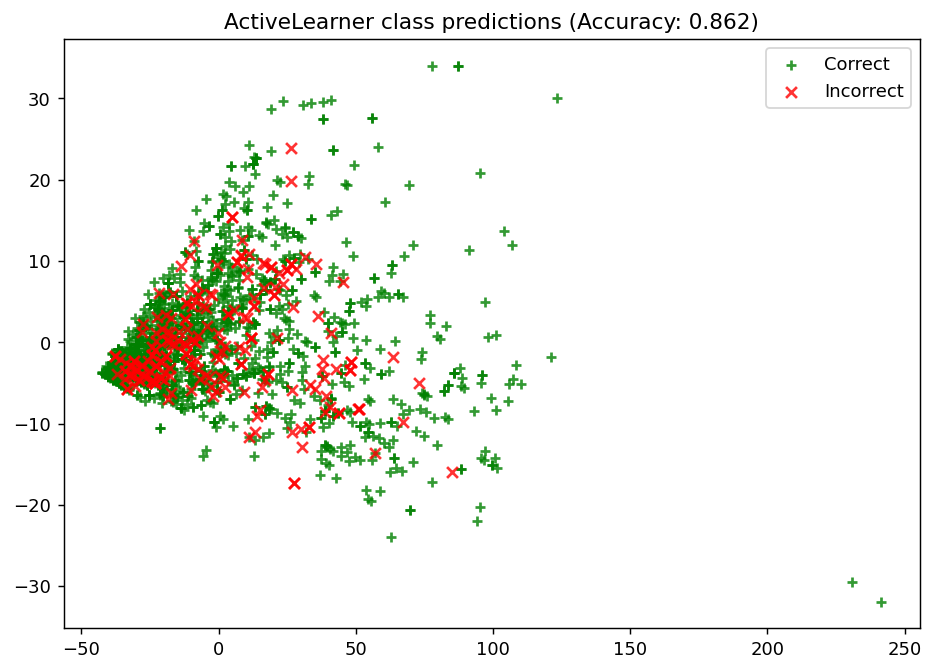

In [ ]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=performance_history[-1]))
plt.show()

In [ ]:
from modAL.uncertainty import margin_sampling

In [ ]:
learner_margin = ActiveLearner(
    estimator = RandomForestClassifier(),
    query_strategy = margin_sampling,
    X_training = x_train, y_training = y_train
)

In [ ]:
y_pool = wine_pool['quality']
x_pool= wine_pool.drop('quality', axis = 1)
x_pool = x_pool.to_numpy()
y_pool = y_pool.to_numpy()

In [ ]:
predictions = learner_margin.predict(x)
is_correct = (predictions == y)
predictions

array([5, 5, 5, ..., 6, 5, 6])

In [ ]:
unqueried_score = learner_margin.score(x, y)

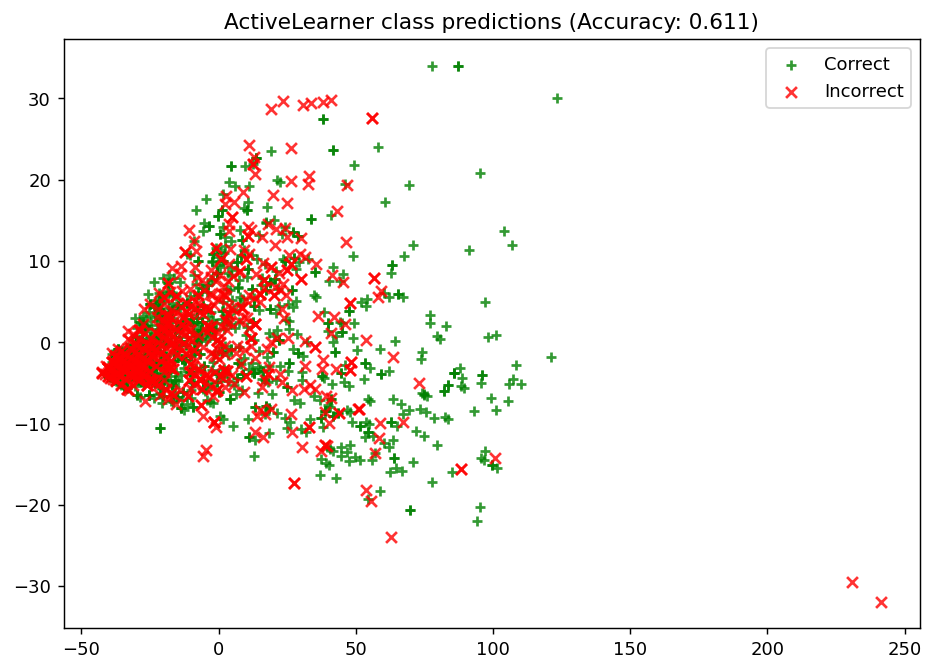

In [ ]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 640
performance_history = [unqueried_score]
checkpoints = []

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner_margin.query(x_pool)

  # Teach our ActiveLearner model the record it has requested.
  learner_margin.teach(X=x_pool[query_index], y=y_pool[query_index])

  # Remove the queried instance from the unlabeled pool.
  x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner_margin.score(x, y)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

  if (index+1)%160 == 0:
    checkpoints.append(model_accuracy)
    print('Checkpoint Accuracy: {acc: 0.4f}'.format(acc = model_accuracy))

Accuracy after query 1: 0.6179
Accuracy after query 2: 0.6285
Accuracy after query 3: 0.6223
Accuracy after query 4: 0.6135
Accuracy after query 5: 0.6098
Accuracy after query 6: 0.6241
Accuracy after query 7: 0.6035
Accuracy after query 8: 0.6085
Accuracy after query 9: 0.6166
Accuracy after query 10: 0.6241
Accuracy after query 11: 0.6273
Accuracy after query 12: 0.6273
Accuracy after query 13: 0.6341
Accuracy after query 14: 0.6141
Accuracy after query 15: 0.6148
Accuracy after query 16: 0.6079
Accuracy after query 17: 0.6160
Accuracy after query 18: 0.6316
Accuracy after query 19: 0.6323
Accuracy after query 20: 0.6285
Accuracy after query 21: 0.6323
Accuracy after query 22: 0.6216
Accuracy after query 23: 0.6110
Accuracy after query 24: 0.6216
Accuracy after query 25: 0.6341
Accuracy after query 26: 0.6191
Accuracy after query 27: 0.6279
Accuracy after query 28: 0.6266
Accuracy after query 29: 0.6235
Accuracy after query 30: 0.6354
Accuracy after query 31: 0.6329
Accuracy after qu

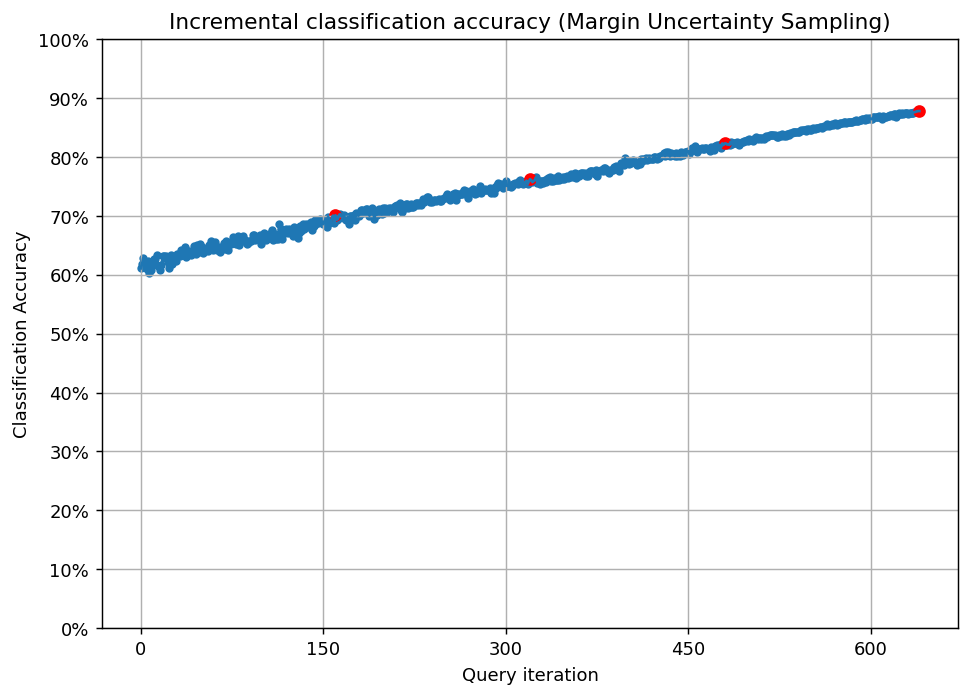

In [ ]:
# Plot our performance over time.
x_list = []
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

for i in range(len(checkpoints)):
  x_c = (i + 1)*160
  x_list.append(x_c)

ax.scatter(x_list, checkpoints, color ='red')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy (Margin Uncertainty Sampling)')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
predictions = learner_margin.predict(x)
is_correct = (predictions == y)

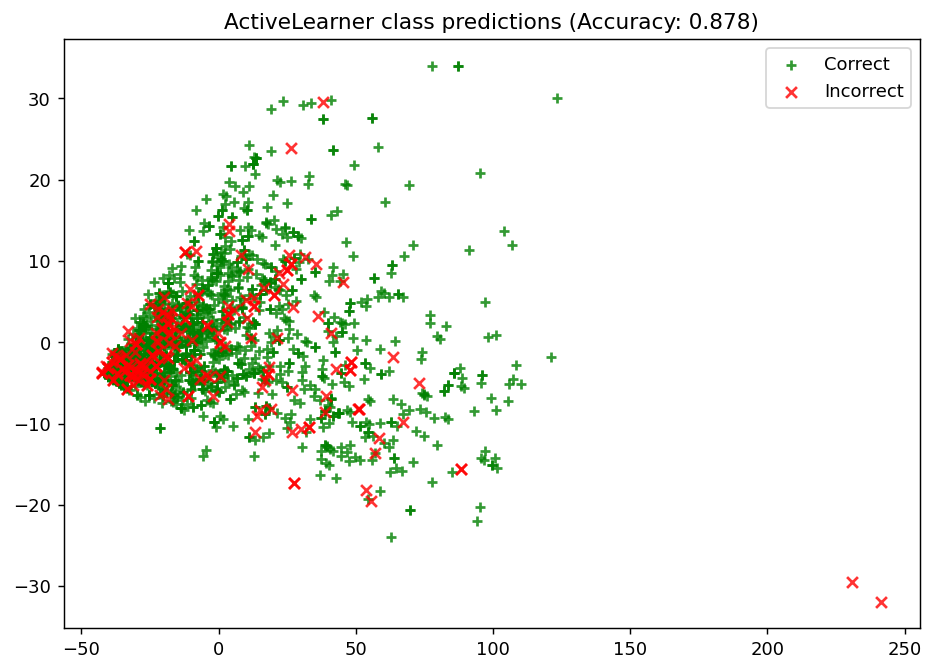

In [ ]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=performance_history[-1]))
plt.show()

In [ ]:
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling

n_members = 5
learner_list = list()

for member_idx in range(n_members):

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=x_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee_ve = Committee(learner_list=learner_list,
                      query_strategy = vote_entropy_sampling)

In [ ]:
unqueried_score = committee_ve.score(x,y)

In [ ]:
unqueried_score

0.6235146966854284

In [ ]:
y_pool = wine_pool['quality']
x_pool= wine_pool.drop('quality', axis = 1)
x_pool = x_pool.to_numpy()
y_pool = y_pool.to_numpy()

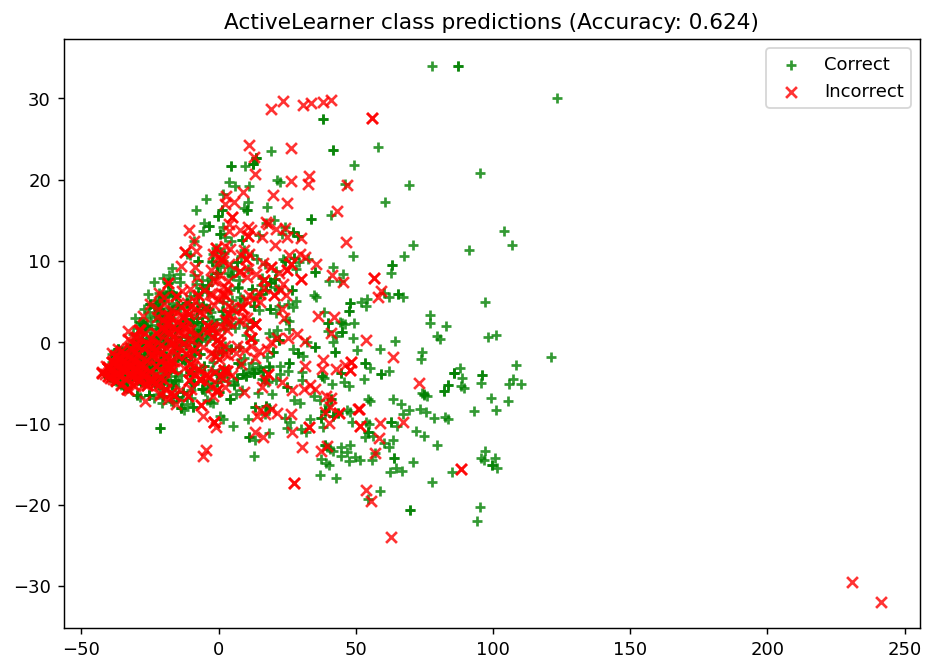

In [ ]:
predictions = committee_ve.predict(x)
is_correct = (predictions == y)

fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 640
performance_history = [unqueried_score]
checkpoints = []

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = committee_ve.query(x_pool)

  # Teach our ActiveLearner model the record it has requested.
  committee_ve.teach(X=x_pool[query_index], y=y_pool[query_index])

  # Remove the queried instance from the unlabeled pool.
  x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = committee_ve.score(x, y)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

  if (index+1)%160 == 0:
    checkpoints.append(model_accuracy)
    print('Checkpoint Accuracy: {acc: 0.4f}'.format(acc = model_accuracy))

Accuracy after query 1: 0.6129
Accuracy after query 2: 0.6154
Accuracy after query 3: 0.6173
Accuracy after query 4: 0.6185
Accuracy after query 5: 0.6173
Accuracy after query 6: 0.6279
Accuracy after query 7: 0.6235
Accuracy after query 8: 0.6273
Accuracy after query 9: 0.6235
Accuracy after query 10: 0.6323
Accuracy after query 11: 0.6254
Accuracy after query 12: 0.6310
Accuracy after query 13: 0.6229
Accuracy after query 14: 0.6248
Accuracy after query 15: 0.6179
Accuracy after query 16: 0.6304
Accuracy after query 17: 0.6316
Accuracy after query 18: 0.6304
Accuracy after query 19: 0.6310
Accuracy after query 20: 0.6360
Accuracy after query 21: 0.6379
Accuracy after query 22: 0.6316
Accuracy after query 23: 0.6429
Accuracy after query 24: 0.6291
Accuracy after query 25: 0.6423
Accuracy after query 26: 0.6391
Accuracy after query 27: 0.6379
Accuracy after query 28: 0.6460
Accuracy after query 29: 0.6473
Accuracy after query 30: 0.6604
Accuracy after query 31: 0.6460
Accuracy after qu

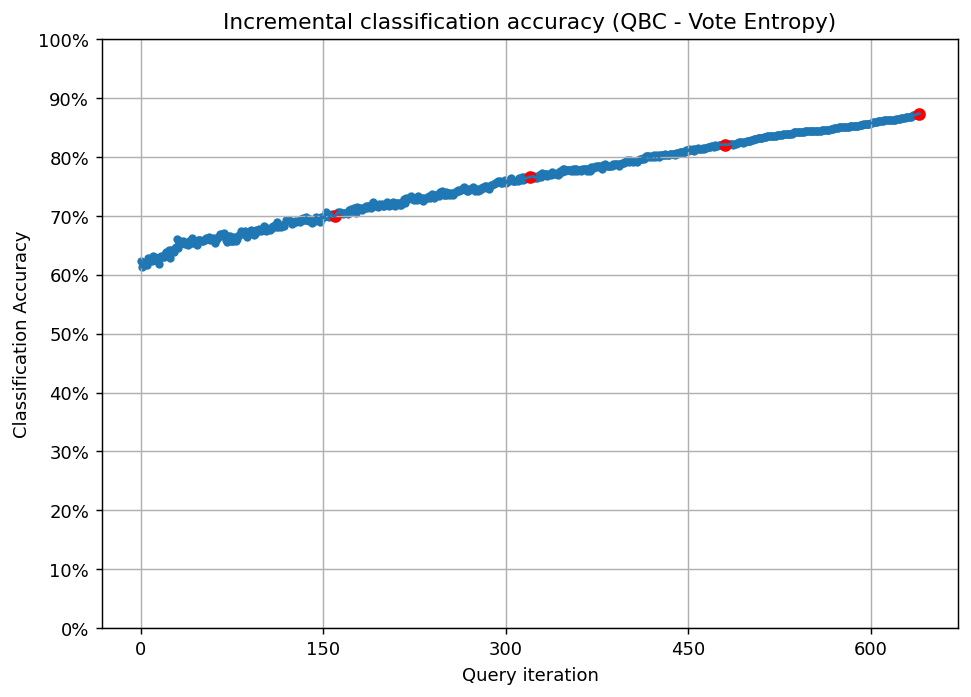

In [ ]:
# Plot our performance over time.
x_list = []
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history, markevery = checkpoints)
ax.scatter(range(len(performance_history)), performance_history, s=13)

for i in range(len(checkpoints)):
  x_c = (i + 1)*160
  x_list.append(x_c)

ax.scatter(x, checkpoints, color ='red')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy (QBC - Vote Entropy)')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

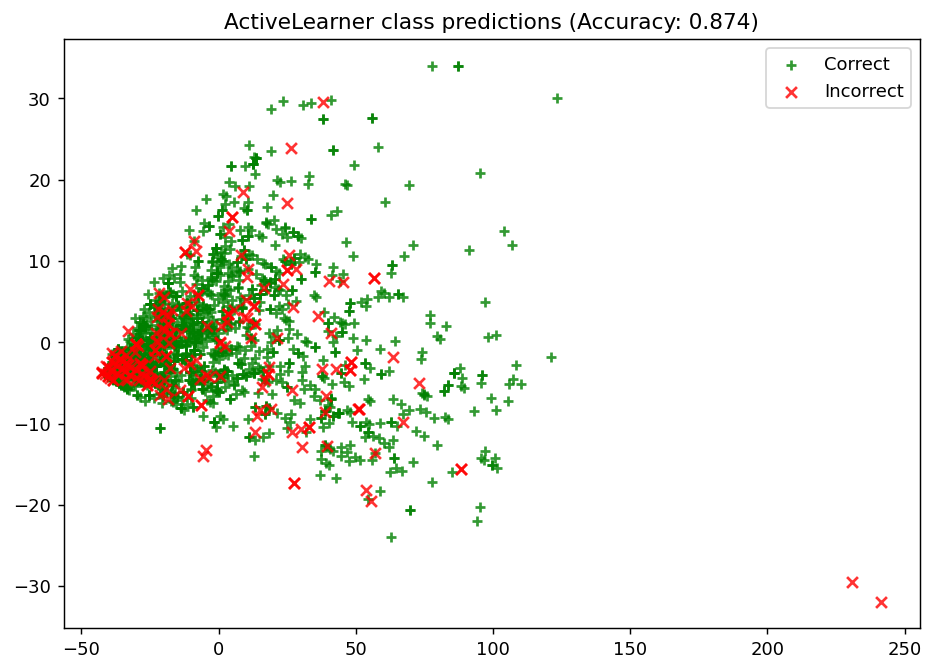

In [ ]:
predictions = committee_ve.predict(x)
is_correct = (predictions == y)

fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=performance_history[-1]))
plt.show()

In [ ]:
from modAL.disagreement import max_disagreement_sampling
n_members = 5
learner_list = list()

for member_idx in range(n_members):

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=x_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee_kl = Committee(learner_list=learner_list,
                      query_strategy = max_disagreement_sampling)

In [ ]:
unqueried_score = committee_kl.score(x,y)

In [ ]:
unqueried_score

0.6191369606003753

In [ ]:
y_pool = wine_pool['quality']
x_pool= wine_pool.drop('quality', axis = 1)
x_pool = x_pool.to_numpy()
y_pool = y_pool.to_numpy()

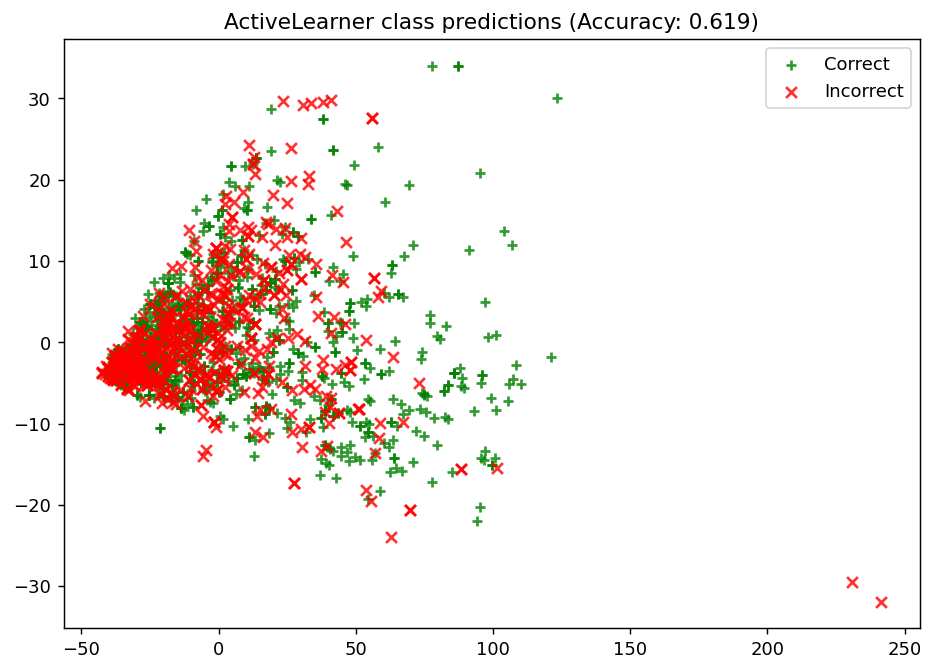

In [ ]:
predictions = committee_kl.predict(x)
is_correct = (predictions == y)

fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 640
performance_history = [unqueried_score]
checkpoints = []

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = committee_kl.query(x_pool)

  # Teach our ActiveLearner model the record it has requested.
  committee_kl.teach(X=x_pool[query_index], y=y_pool[query_index])

  # Remove the queried instance from the unlabeled pool.
  x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = committee_kl.score(x, y)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

  if (index+1)%160 == 0:
    checkpoints.append(model_accuracy)
    print('Checkpoint Accuracy: {acc: 0.4f}'.format(acc = model_accuracy))

Accuracy after query 1: 0.6304
Accuracy after query 2: 0.6216
Accuracy after query 3: 0.6135
Accuracy after query 4: 0.6204
Accuracy after query 5: 0.6229
Accuracy after query 6: 0.6273
Accuracy after query 7: 0.6348
Accuracy after query 8: 0.6235
Accuracy after query 9: 0.6291
Accuracy after query 10: 0.6273
Accuracy after query 11: 0.6304
Accuracy after query 12: 0.6279
Accuracy after query 13: 0.6304
Accuracy after query 14: 0.6266
Accuracy after query 15: 0.6223
Accuracy after query 16: 0.6285
Accuracy after query 17: 0.6316
Accuracy after query 18: 0.6241
Accuracy after query 19: 0.6329
Accuracy after query 20: 0.6279
Accuracy after query 21: 0.6398
Accuracy after query 22: 0.6291
Accuracy after query 23: 0.6354
Accuracy after query 24: 0.6354
Accuracy after query 25: 0.6323
Accuracy after query 26: 0.6273
Accuracy after query 27: 0.6348
Accuracy after query 28: 0.6285
Accuracy after query 29: 0.6310
Accuracy after query 30: 0.6404
Accuracy after query 31: 0.6335
Accuracy after qu

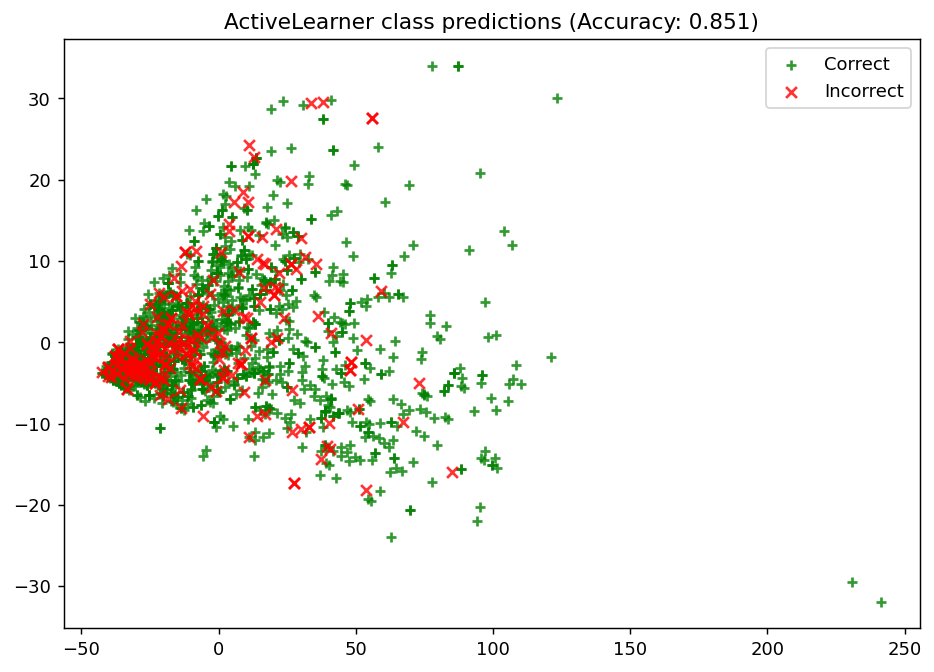

In [ ]:
predictions = committee_kl.predict(x)
is_correct = (predictions == y)

fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='upper right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=performance_history[-1]))
plt.show()

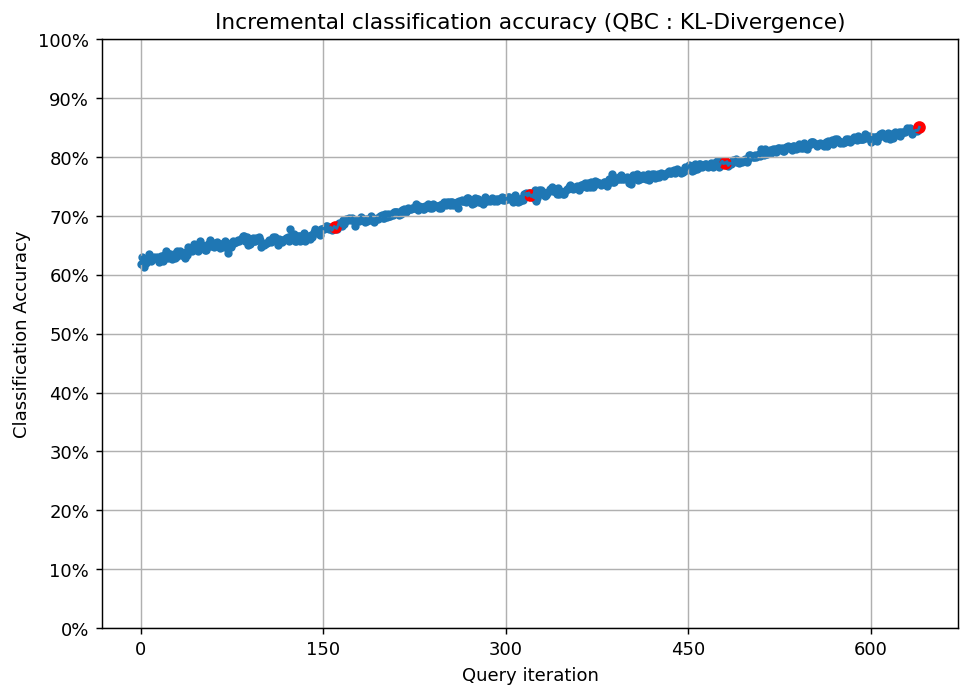

In [ ]:
# Plot our performance over time.
x_list = []
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history, markevery = checkpoints)
ax.scatter(range(len(performance_history)), performance_history, s=13)

for i in range(len(checkpoints)):
  x_c = (i + 1)*160
  x_list.append(x_c)

ax.scatter(x_list, checkpoints, color ='red')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy (QBC : KL-Divergence)')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

Training a Random Forest Classifier on randomly chosen data.

In [ ]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
wine_10 = wine_df.sample(frac = 0.1, random_state = 21)

In [ ]:
y_train_10 = wine_10['quality']
y_train_10

275     6
551     6
893     5
1535    6
494     6
       ..
131     5
547     6
851     5
532     5
590     5
Name: quality, Length: 160, dtype: int64

In [ ]:
y_train_10.unique()

array([6, 5, 7, 4, 8, 3])

In [ ]:
x_train_10 = wine_10.drop('quality', axis =1)
x_train_10

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
275,7.9,0.545,0.06,4.0,0.087,27.0,61.0,0.99650,3.36,0.67,10.7
551,9.4,0.430,0.24,2.8,0.092,14.0,45.0,0.99800,3.19,0.73,10.0
893,7.2,0.660,0.03,2.3,0.078,16.0,86.0,0.99743,3.53,0.57,9.7
1535,7.0,0.550,0.13,2.2,0.075,15.0,35.0,0.99590,3.36,0.59,9.7
494,6.5,0.390,0.23,8.3,0.051,28.0,91.0,0.99520,3.44,0.55,12.1
...,...,...,...,...,...,...,...,...,...,...,...
131,5.6,0.500,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0
547,10.6,0.310,0.49,2.5,0.067,6.0,21.0,0.99870,3.26,0.86,10.7
851,9.3,0.430,0.44,1.9,0.085,9.0,22.0,0.99708,3.28,0.55,9.5
532,11.9,0.380,0.49,2.7,0.098,12.0,42.0,1.00040,3.16,0.61,10.3


In [ ]:
x_train_10 = x_train_10.to_numpy()

In [ ]:
y_train_10 = y_train_10.to_numpy()

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
passive_model = LogisticRegression()

In [ ]:
passive_model.fit(x_train_10, y_train_10)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
passive_model.score(x,y)

0.5447154471544715

In [ ]:
wine_20 = wine_df.sample(frac = 0.2, random_state = 21)

In [ ]:
y_train_20 = wine_20['quality']
y_train_20

275     6
551     6
893     5
1535    6
494     6
       ..
1394    5
1028    6
1522    5
242     6
786     5
Name: quality, Length: 320, dtype: int64

In [ ]:
y_train_20.unique()

array([6, 5, 7, 4, 8, 3])

In [ ]:
x_train_20 = wine_20.drop('quality', axis =1)
x_train_20

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
275,7.9,0.545,0.06,4.0,0.087,27.0,61.0,0.99650,3.36,0.67,10.7
551,9.4,0.430,0.24,2.8,0.092,14.0,45.0,0.99800,3.19,0.73,10.0
893,7.2,0.660,0.03,2.3,0.078,16.0,86.0,0.99743,3.53,0.57,9.7
1535,7.0,0.550,0.13,2.2,0.075,15.0,35.0,0.99590,3.36,0.59,9.7
494,6.5,0.390,0.23,8.3,0.051,28.0,91.0,0.99520,3.44,0.55,12.1
...,...,...,...,...,...,...,...,...,...,...,...
1394,6.4,0.570,0.14,3.9,0.070,27.0,73.0,0.99669,3.32,0.48,9.2
1028,7.2,0.340,0.21,2.5,0.075,41.0,68.0,0.99586,3.37,0.54,10.1
1522,6.1,0.320,0.25,2.3,0.071,23.0,58.0,0.99633,3.42,0.97,10.6
242,7.7,0.580,0.10,1.8,0.102,28.0,109.0,0.99565,3.08,0.49,9.8


In [ ]:
x_train_20 = x_train_20.to_numpy()

In [ ]:
y_train_20 = y_train_20.to_numpy()

In [ ]:
passive_model_20 = LogisticRegression()

In [ ]:
passive_model_20.fit(x_train_20, y_train_20)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
passive_model_20.score(x,y)

0.5853658536585366

In [ ]:
wine_30 = wine_df.sample(frac = 0.3, random_state = 21)

In [ ]:
y_train_30 = wine_30['quality']
y_train_30

275     6
551     6
893     5
1535    6
494     6
       ..
3       6
686     5
528     6
623     6
518     6
Name: quality, Length: 480, dtype: int64

In [ ]:
y_train_30.unique()

array([6, 5, 7, 4, 8, 3])

In [ ]:
x_train_30 = wine_30.drop('quality', axis =1)
x_train_30

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
275,7.9,0.545,0.06,4.0,0.087,27.0,61.0,0.99650,3.36,0.67,10.7
551,9.4,0.430,0.24,2.8,0.092,14.0,45.0,0.99800,3.19,0.73,10.0
893,7.2,0.660,0.03,2.3,0.078,16.0,86.0,0.99743,3.53,0.57,9.7
1535,7.0,0.550,0.13,2.2,0.075,15.0,35.0,0.99590,3.36,0.59,9.7
494,6.5,0.390,0.23,8.3,0.051,28.0,91.0,0.99520,3.44,0.55,12.1
...,...,...,...,...,...,...,...,...,...,...,...
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
686,7.1,0.650,0.18,1.8,0.070,13.0,40.0,0.99700,3.44,0.60,9.1
528,8.2,0.420,0.49,2.6,0.084,32.0,55.0,0.99880,3.34,0.75,8.7
623,7.9,0.510,0.25,2.9,0.077,21.0,45.0,0.99740,3.49,0.96,12.1


In [ ]:
x_train_30 = x_train_30.to_numpy()

In [ ]:
y_train_30 = y_train_30.to_numpy()

In [ ]:
passive_model_30 = LogisticRegression()

In [ ]:
passive_model_30.fit(x_train_30, y_train_30)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
passive_model_30.score(x,y)

0.5778611632270169

In [ ]:
wine_40 = wine_df.sample(frac = 0.4, random_state = 21)

In [ ]:
y_train_40 = wine_40['quality']
y_train_40

275     6
551     6
893     5
1535    6
494     6
       ..
1422    6
462     5
87      5
685     5
176     5
Name: quality, Length: 640, dtype: int64

In [ ]:
y_train_40.unique()

array([6, 5, 7, 4, 8, 3])

In [ ]:
x_train_40 = wine_40.drop('quality', axis =1)
x_train_40

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
275,7.9,0.545,0.06,4.00,0.087,27.0,61.0,0.99650,3.36,0.67,10.7
551,9.4,0.430,0.24,2.80,0.092,14.0,45.0,0.99800,3.19,0.73,10.0
893,7.2,0.660,0.03,2.30,0.078,16.0,86.0,0.99743,3.53,0.57,9.7
1535,7.0,0.550,0.13,2.20,0.075,15.0,35.0,0.99590,3.36,0.59,9.7
494,6.5,0.390,0.23,8.30,0.051,28.0,91.0,0.99520,3.44,0.55,12.1
...,...,...,...,...,...,...,...,...,...,...,...
1422,7.0,0.540,0.00,2.10,0.079,39.0,55.0,0.99560,3.39,0.84,11.4
462,11.0,0.260,0.68,2.55,0.085,10.0,25.0,0.99700,3.18,0.61,11.8
87,7.7,0.490,0.26,1.90,0.062,9.0,31.0,0.99660,3.39,0.64,9.6
685,8.1,0.780,0.23,2.60,0.059,5.0,15.0,0.99700,3.37,0.56,11.3


In [ ]:
x_train_40 = x_train_40.to_numpy()

In [ ]:
y_train_40 = y_train_40.to_numpy()

In [ ]:
passive_model_40 = LogisticRegression()

In [ ]:
passive_model_40.fit(x_train_40, y_train_40)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
passive_model_40.score(x,y)

0.5722326454033771

In [ ]:
wine_50 = wine_df.sample(frac = 0.5, random_state = 21)

In [ ]:
y_train_50 = wine_50['quality']
y_train_50

275     6
551     6
893     5
1535    6
494     6
       ..
1090    8
598     6
729     6
1360    5
1573    6
Name: quality, Length: 800, dtype: int64

In [ ]:
y_train_50.unique()

array([6, 5, 7, 4, 8, 3])

In [ ]:
x_train_50 = wine_50.drop('quality', axis =1)
x_train_50

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
275,7.9,0.545,0.06,4.0,0.087,27.0,61.0,0.99650,3.36,0.67,10.7
551,9.4,0.430,0.24,2.8,0.092,14.0,45.0,0.99800,3.19,0.73,10.0
893,7.2,0.660,0.03,2.3,0.078,16.0,86.0,0.99743,3.53,0.57,9.7
1535,7.0,0.550,0.13,2.2,0.075,15.0,35.0,0.99590,3.36,0.59,9.7
494,6.5,0.390,0.23,8.3,0.051,28.0,91.0,0.99520,3.44,0.55,12.1
...,...,...,...,...,...,...,...,...,...,...,...
1090,10.0,0.260,0.54,1.9,0.083,42.0,74.0,0.99451,2.98,0.63,11.8
598,8.5,0.585,0.18,2.1,0.078,5.0,30.0,0.99670,3.20,0.48,9.8
729,6.4,0.865,0.03,3.2,0.071,27.0,58.0,0.99500,3.61,0.49,12.7
1360,9.2,0.540,0.31,2.3,0.112,11.0,38.0,0.99699,3.24,0.56,10.9


In [ ]:
x_train_50 = x_train_50.to_numpy()

In [ ]:
y_train_50 = y_train_50.to_numpy()

In [ ]:
passive_model_50 = LogisticRegression()

In [ ]:
passive_model_50.fit(x_train_50, y_train_50)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
passive_model_50.score(x,y)

0.5809881175734835

In [ ]:
passive_model_c = LogisticRegression()

In [ ]:
passive_model_c.fit(x,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
passive_model_c.score(x,y)

0.5797373358348968

In [ ]:
wine_pool

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
275,7.9,0.545,0.06,4.0,0.087,27.0,61.0,0.99650,3.36,0.67,10.7,6
551,9.4,0.430,0.24,2.8,0.092,14.0,45.0,0.99800,3.19,0.73,10.0,6
893,7.2,0.660,0.03,2.3,0.078,16.0,86.0,0.99743,3.53,0.57,9.7,5
1535,7.0,0.550,0.13,2.2,0.075,15.0,35.0,0.99590,3.36,0.59,9.7,6
494,6.5,0.390,0.23,8.3,0.051,28.0,91.0,0.99520,3.44,0.55,12.1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1368,8.0,0.770,0.32,2.1,0.079,16.0,74.0,0.99656,3.27,0.50,9.8,6
672,9.8,1.240,0.34,2.0,0.079,32.0,151.0,0.99800,3.15,0.53,9.5,5
1287,8.0,0.600,0.08,2.6,0.056,3.0,7.0,0.99286,3.22,0.37,13.0,5
259,10.0,0.310,0.47,2.6,0.085,14.0,33.0,0.99965,3.36,0.80,10.5,7


In [ ]:
wine_clustering = wine_pool.sample(frac=0.4, random_state = 20)

In [ ]:
x_cluster = wine_clustering.drop('quality', axis =1)
x_cluster

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1285,11.3,0.370,0.50,1.8,0.090,20.0,47.0,0.99734,3.15,0.57,10.5
1266,7.2,0.570,0.05,2.3,0.081,16.0,36.0,0.99564,3.38,0.60,10.3
1218,8.2,0.400,0.31,1.9,0.082,8.0,24.0,0.99600,3.24,0.69,10.6
439,7.0,0.620,0.18,1.5,0.062,7.0,50.0,0.99510,3.08,0.60,9.3
370,6.9,0.765,0.02,2.3,0.063,35.0,63.0,0.99750,3.57,0.78,9.9
...,...,...,...,...,...,...,...,...,...,...,...
1014,8.0,0.580,0.16,2.0,0.120,3.0,7.0,0.99454,3.22,0.58,11.2
1442,6.9,0.630,0.02,1.9,0.078,18.0,30.0,0.99712,3.40,0.75,9.8
1058,9.9,0.530,0.57,2.4,0.093,30.0,52.0,0.99710,3.19,0.76,11.6
1150,8.2,0.330,0.32,2.8,0.067,4.0,12.0,0.99473,3.30,0.76,12.8


In [ ]:
y_cluster = wine_clustering['quality']

In [ ]:
y_cluster

1285    5
1266    6
1218    6
439     5
370     5
       ..
1014    6
1442    5
1058    7
1150    7
1188    5
Name: quality, Length: 576, dtype: int64

In [ ]:
y_cluster.unique()

array([5, 6, 3, 7, 4, 8])

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
km = KMeans(
    n_clusters = 6, n_init = 50,
    init = 'random',
    max_iter = 500, random_state = 42
)

In [ ]:
y_km = km.fit_predict(x_cluster)

In [ ]:
len(y_km)

576

In [ ]:
y_km

array([1, 1, 0, 1, 4, 1, 2, 1, 0, 4, 5, 4, 1, 1, 0, 0, 1, 4, 1, 0, 5, 0,
       0, 4, 0, 0, 1, 0, 0, 0, 5, 4, 4, 1, 0, 1, 0, 0, 0, 0, 4, 0, 1, 4,
       0, 4, 1, 1, 5, 1, 0, 0, 2, 1, 4, 2, 2, 0, 1, 0, 2, 1, 1, 1, 4, 0,
       1, 0, 2, 1, 0, 4, 4, 2, 5, 1, 0, 1, 0, 4, 0, 1, 0, 4, 5, 1, 0, 1,
       4, 0, 4, 0, 1, 1, 0, 4, 2, 5, 1, 0, 2, 2, 0, 4, 4, 4, 0, 1, 5, 1,
       1, 1, 4, 1, 0, 4, 0, 0, 4, 0, 2, 0, 5, 4, 1, 5, 4, 1, 0, 4, 0, 1,
       4, 3, 1, 2, 4, 1, 0, 2, 4, 0, 1, 0, 1, 4, 1, 2, 1, 0, 5, 0, 2, 1,
       0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 4, 0, 1, 2, 1, 0, 2, 0, 1,
       1, 5, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 1, 1, 0, 1, 0, 1, 4,
       0, 0, 5, 4, 1, 0, 0, 4, 2, 5, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0, 2, 0,
       0, 0, 0, 2, 1, 0, 4, 5, 0, 1, 2, 4, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0,
       5, 0, 4, 2, 5, 3, 4, 1, 2, 1, 2, 0, 4, 1, 5, 5, 2, 4, 4, 0, 5, 1,
       1, 1, 0, 0, 0, 2, 1, 4, 0, 1, 1, 4, 0, 1, 0, 1, 2, 5, 5, 4, 0, 1,
       0, 2, 0, 2, 0, 1, 4, 0, 4, 1, 5, 4, 2, 0, 1,

In [ ]:
km.cluster_centers_

array([[8.56306306e+00, 5.05045045e-01, 2.96396396e-01, 2.54121622e+00,
        8.54954955e-02, 7.51351351e+00, 1.90540541e+01, 9.96697342e-01,
        3.29878378e+00, 6.62252252e-01, 1.06860360e+01],
       [8.13496503e+00, 5.30209790e-01, 2.40000000e-01, 2.51503497e+00,
        9.09510490e-02, 1.60979021e+01, 4.12727273e+01, 9.96574196e-01,
        3.32804196e+00, 6.46713287e-01, 1.04500000e+01],
       [7.82000000e+00, 5.51285714e-01, 2.82428571e-01, 3.41785714e+00,
        9.23714286e-02, 2.30285714e+01, 9.32142857e+01, 9.96958000e-01,
        3.30871429e+00, 6.69142857e-01, 1.01895238e+01],
       [7.90000000e+00, 3.00000000e-01, 6.80000000e-01, 8.30000000e+00,
        5.00000000e-02, 3.75000000e+01, 2.83500000e+02, 9.93160000e-01,
        3.01000000e+00, 5.10000000e-01, 1.23000000e+01],
       [8.26930693e+00, 5.13712871e-01, 2.76138614e-01, 2.40000000e+00,
        9.07326733e-02, 2.66831683e+01, 6.16584158e+01, 9.96983168e-01,
        3.33485149e+00, 6.93168317e-01, 1.03787129e+

In [ ]:
preds = []
for i in range(6):
    y_single = y_cluster[y_km == i]
    # print(len(y_single))
    r = [10, 20, 30, 40, 50, 60]
    y_frac = y_single.sample(frac = 0.2, random_state= r[i])
    # print(y_frac)
    try:
      max = y_frac.value_counts().index[0]
    except:
      pass

    for index, value in y_single.items():
      y_single[index] = max

    print(y_single)
    preds.append(y_single)

1218    6
816     6
690     6
96      6
444     6
       ..
437     6
627     6
572     6
1014    6
1150    6
Name: quality, Length: 222, dtype: int64
1285    6
1266    6
439     6
306     6
686     6
       ..
551     6
1245    6
403     6
136     6
1442    6
Name: quality, Length: 143, dtype: int64
1434    5
1222    5
1382    5
1198    5
198     5
       ..
499     5
864     5
1278    5
738     5
703     5
Name: quality, Length: 70, dtype: int64
1081    5
1079    5
Name: quality, dtype: int64
370     6
323     6
878     6
196     6
422     6
       ..
625     6
932     6
1516    6
318     6
1058    6
Name: quality, Length: 101, dtype: int64
636     5
463     5
1558    5
154     5
637     5
524     5
219     5
332     5
53      5
155     5
562     5
156     5
157     5
188     5
313     5
523     5
1400    5
1559    5
1496    5
46      5
396     5
1184    5
905     5
789     5
163     5
130     5
771     5
651     5
591     5
1131    5
201     5
145     5
92      5
1389    5
522     5

In [ ]:
sum = 0
n = 0
for i in range(len(preds)):
  is_correct = (preds[i] == y_cluster[y_km == i])
  sum = sum + np.sum(is_correct)
  n = n + len(preds[i])

print(100*sum/n)

46.701388888888886


In [ ]:
is_correct

636     True
463     True
1558    True
154     True
637     True
524     True
219     True
332     True
53      True
155     True
562     True
156     True
157     True
188     True
313     True
523     True
1400    True
1559    True
1496    True
46      True
396     True
1184    True
905     True
789     True
163     True
130     True
771     True
651     True
591     True
1131    True
201     True
145     True
92      True
1389    True
522     True
88      True
354     True
1188    True
Name: quality, dtype: bool

In [ ]:
y_single_new

636                       5
463                       5
1558                      5
154                       5
637                       5
               ...         
33      0    5
dtype: int64
34      0    5
dtype: int64
35      0    5
dtype: int64
36      0    5
dtype: int64
37      0    5
dtype: int64
Name: quality, Length: 76, dtype: object

In [ ]:
y_single

0    5
dtype: int64

In [ ]:
learner_stream = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=x_train, y_training=y_train
)

unqueried_score = learner_stream.score(x, y)

In [ ]:
from modAL.uncertainty import classifier_uncertainty
performance_history = [unqueried_score]
unqueried_score

0.6278924327704816

In [ ]:
y_pool = wine_pool['quality']
x_pool= wine_pool.drop('quality', axis = 1)
x_pool = x_pool.to_numpy()
y_pool = y_pool.to_numpy()

In [ ]:
stream_idx = np.random.choice(range(len(x_pool)))

In [ ]:
stream_idx

263

In [ ]:
from modAL.uncertainty import classifier_margin, classifier_entropy

In [ ]:
for i in range(1440):
  if i == 0:
    min_uncertainty = classifier_entropy(learner_stream, x_pool[i].reshape(1,-1))
  if classifier_entropy(learner_stream, x_pool[i].reshape(1,-1)) < min_uncertainty:
    n = i
    min_uncertainty = classifier_entropy(learner_stream, x_pool[i].reshape(1,-1))

print(n,min_uncertainty)

345 [0.22353536]


In [ ]:
max_uncertainty = 0
for i in range(1440):
  if classifier_margin(learner_stream, x_pool[i].reshape(1,-1)) > max_uncertainty:
    n = i
    max_uncertainty = classifier_margin(learner_stream, x_pool[i].reshape(1,-1))

print(n,max_uncertainty)

150 [0.92]


In [ ]:
while learner_stream.score(x, y) < 0.9:
  stream_idx = np.random.choice(range(len(x_pool)))
  if classifier_uncertainty(learner_stream, x_pool[stream_idx].reshape(1, -1)) >=0.4:
    learner_stream.teach(x_pool[stream_idx].reshape(1, -1), y_pool[stream_idx].reshape(-1,))
    new_score = learner_stream.score(x, y)
    performance_history.append(new_score)
    print('Data point %d queried, new accuracy: %f' % (stream_idx, new_score))

Data point 776 queried, new accuracy: 0.619137
Data point 703 queried, new accuracy: 0.623515
Data point 1160 queried, new accuracy: 0.607880
Data point 306 queried, new accuracy: 0.615385
Data point 254 queried, new accuracy: 0.614134
Data point 253 queried, new accuracy: 0.619137
Data point 789 queried, new accuracy: 0.614134
Data point 383 queried, new accuracy: 0.623515
Data point 1217 queried, new accuracy: 0.615385
Data point 634 queried, new accuracy: 0.619137
Data point 304 queried, new accuracy: 0.631019
Data point 21 queried, new accuracy: 0.624140
Data point 639 queried, new accuracy: 0.619762
Data point 597 queried, new accuracy: 0.612258
Data point 677 queried, new accuracy: 0.617261
Data point 1278 queried, new accuracy: 0.632270
Data point 797 queried, new accuracy: 0.627892
Data point 1370 queried, new accuracy: 0.633521
Data point 165 queried, new accuracy: 0.631645
Data point 163 queried, new accuracy: 0.632896
Data point 621 queried, new accuracy: 0.632896
Data point

In [ ]:
len(performance_history) - 1

702

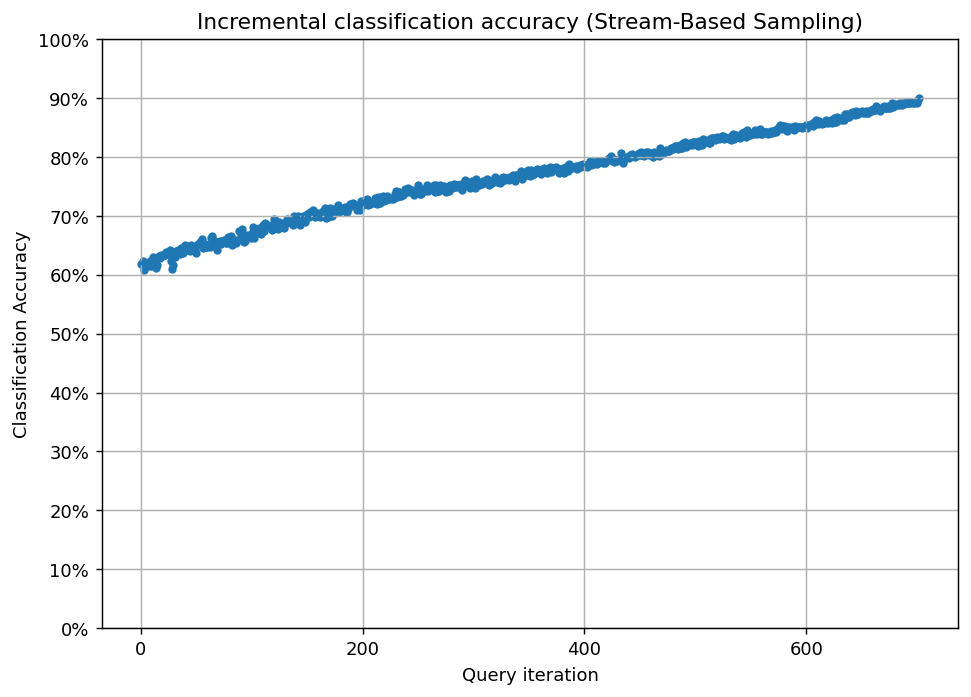

In [ ]:
# Plot our performance over time.
x_list = []
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

# ax.scatter(x_list, checkpoints, color ='red')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy (Stream-Based Sampling)')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
y_pool = wine_pool['quality']
x_pool= wine_pool.drop('quality', axis = 1)

In [ ]:
x_pool = x_pool.to_numpy()
y_pool = y_pool.to_numpy()

In [ ]:
new_learner = ActiveLearner(
    estimator = RandomForestClassifier(),
    X_training = x_train, y_training = y_train
)

In [ ]:
classifier_uncertainty(new_learner, x_pool[stream_idx])

ValueError: ignored

In [ ]:
x_pool.reshape(-1,1)

array([[ 7.9  ],
       [ 0.545],
       [ 0.06 ],
       ...,
       [ 3.43 ],
       [ 0.56 ],
       [11.2  ]])